In [36]:
EXTRACTED_FASTQ = '/scratch/users/yigit.babal/ferret/corrected_output/ED221124_barcode_extracted.fastq' # path to extracted fasq files containing lineage barcodes
REFORMATTED_FASTA = "/scratch/users/yigit.babal/ferret/corrected_output/ED221124_barcode_reformat.fa" # path to reformatted fasta fileRE
LIB = "ED221124," # string indicating which library the file came from including the comma
LIB_TXT = '/scratch/users/yigit.babal/ferret/corrected_output/ED221124_lib.txt' # path to library text file for input into LARRY

In [37]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""
    
def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [38]:
file = open(EXTRACTED_FASTQ, 'r')
barcodeList = file.readlines()

In [39]:
for i in range(0, len(barcodeList), 4):
    barcodeList[i] = ">" + LIB + find_between(barcodeList[i], "_", "_" ) + "," + find_between_r(barcodeList[i], "_", " ")

In [40]:
with open(REFORMATTED_FASTA,"w") as f:
    for i in range(0,len(barcodeList), 4):
        f.write(str(barcodeList[i]) + "\n" + str(barcodeList[i+1]))

In [41]:
file_list = open(REFORMATTED_FASTA, 'r')
filtered_bc_list = file_list.readlines()
with open(LIB_TXT, "w") as f:
    for i in range(0,len(filtered_bc_list),4):
        f.write(str(find_between(filtered_bc_list[i], ">", ",") + "\n"))

In [1]:
import numpy as np, matplotlib.pyplot as plt, networkx as nx, pickle, json, gzip
import pandas as pd
import itertools

In [2]:
N_READS = 15
N_UMIS = 9
N_HAMMING = 3
CELL_BCS_PATH = "/scratch/users/yigit.babal/ferret/corrected_output/ED221124_whitelist.txt"
LIB_NAMES_PATH = "/scratch/users/yigit.babal/ferret/corrected_output/ED221124_lib.txt"

In [3]:
cell_bcs = pd.read_csv(CELL_BCS_PATH, sep='\t', header = None)
cell_bcs = cell_bcs.loc[:,0].tolist()
lib_names = open(LIB_NAMES_PATH).read().strip('\n').split('\n')

In [4]:
counts = {}
f = open("/scratch/users/yigit.babal/ferret/corrected_output/ED221124_barcode_reformat.fa")
l = f.readline().strip('\n')
current_tag = []
i = 0
print('Reading in all barcodes')
while not (l == '' and len(current_tag)==0):
    i += 1
    if i % (3*10**6)==0: print('Processed '+repr(int(i/3))+' reads')
    if l == '':
        current_tag = []
    elif l[0] == '>':
        current_tag = l[1:].split(',')
    elif l != '' and len(current_tag)==3:
        current_tag.append(l)
        current_tag = tuple(current_tag)
        if not current_tag in counts: counts[current_tag] = 0
        counts[current_tag] += 1
        
    l = f.readline().strip('\n')



Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Processed 6000000 reads
Processed 7000000 reads
Processed 8000000 reads
Processed 9000000 reads
Processed 10000000 reads
Processed 11000000 reads
Processed 12000000 reads
Processed 13000000 reads
Processed 14000000 reads
Processed 15000000 reads
Processed 16000000 reads
Processed 17000000 reads
Processed 18000000 reads
Processed 19000000 reads
Processed 20000000 reads
Processed 21000000 reads
Processed 22000000 reads
Processed 23000000 reads
Processed 24000000 reads
Processed 25000000 reads
Processed 26000000 reads
Processed 27000000 reads
Processed 28000000 reads
Processed 29000000 reads
Processed 30000000 reads
Processed 31000000 reads
Processed 32000000 reads
Processed 33000000 reads
Processed 34000000 reads
Processed 35000000 reads
Processed 36000000 reads
Processed 37000000 reads
Processed 38000000 reads
Processed 39000000 reads
Processed 

Retaining 905106 out of 29384802 (Sample,Cell-BC,UMI,GFP-BC) combinations


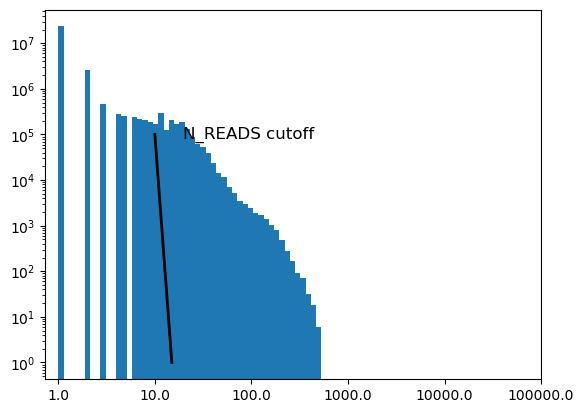

In [5]:

num_reads = [v for k,v in counts.items()]
plt.hist(np.log(num_reads)/np.log(10), bins=50)
plt.plot([np.log(N_READS)/np.log(10),np.log(N_READS)/np.log(N_READS)],[1,10**5],'-k',linewidth=2)
plt.xticks(range(6),np.logspace(0,5,6))
plt.text(np.log(N_READS)/np.log(10)*1.1,10**5*.8,'N_READS cutoff', fontsize=12)
plt.yscale('log')

counts_filtered = {k:v for k,v in counts.items() if v >= N_READS}
print('Retaining '+repr(len(counts_filtered))+ ' out of '+repr(len(counts))+' (Sample,Cell-BC,UMI,GFP-BC) combinations')



In [6]:
import time
from Levenshtein import distance

all_gfp_bcs = sorted(set([k[3] for k in counts_filtered]))

def collapse_barcodes(all_bcs, N_HAMMING=1):
    # Convert the barcodes to a numpy array of strings
    all_bcs_arr = np.array(all_bcs, dtype='U')
    
    # Initialize the list of good barcodes and the barcode map
    good_bcs = []
    bc_map = {}
    
    # Loop through all barcodes
    for i, bc1 in enumerate(all_bcs_arr):
        # Print status
        if i % 500 == 0:
            print('Mapping {} out of {} barcodes'.format(i, len(all_bcs_arr)))
            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time * (len(all_bcs_arr) - i) / (i + 1)
            print('Estimated remaining time: {:.2f} seconds'.format(remaining_time))

        # Try to map the barcode to an existing good barcode
        mapped = False
        for bc2 in good_bcs:
            if distance(bc1, bc2) <= N_HAMMING:
                mapped = True
                bc_map[bc1] = bc2
                break
        if not mapped:
            good_bcs.append(bc1)
    
    return good_bcs, bc_map

# Example usage
print('Collapsing barcodes with Levenshtein distance {}...'.format(N_HAMMING))
start_time = time.time()
good_gfp_bcs, bc_map = collapse_barcodes(all_gfp_bcs, N_HAMMING=N_HAMMING)
end_time = time.time()
print('Done. Elapsed time: {:.2f} seconds'.format(end_time - start_time))


Collapsing barcodes with Levenshtein distance 3...
Mapping 0 out of 220706 barcodes
Estimated remaining time: 14456.62 seconds
Mapping 500 out of 220706 barcodes
Estimated remaining time: 61.41 seconds
Mapping 1000 out of 220706 barcodes
Estimated remaining time: 67.68 seconds
Mapping 1500 out of 220706 barcodes
Estimated remaining time: 82.91 seconds
Mapping 2000 out of 220706 barcodes
Estimated remaining time: 101.95 seconds
Mapping 2500 out of 220706 barcodes
Estimated remaining time: 123.11 seconds
Mapping 3000 out of 220706 barcodes
Estimated remaining time: 144.14 seconds
Mapping 3500 out of 220706 barcodes
Estimated remaining time: 164.21 seconds
Mapping 4000 out of 220706 barcodes
Estimated remaining time: 185.44 seconds
Mapping 4500 out of 220706 barcodes
Estimated remaining time: 206.34 seconds
Mapping 5000 out of 220706 barcodes
Estimated remaining time: 226.11 seconds
Mapping 5500 out of 220706 barcodes
Estimated remaining time: 245.19 seconds
Mapping 6000 out of 220706 bar

In [7]:
print('\nCollapsed '+repr(len(bc_map))+' barcodes')
for bc in good_gfp_bcs: bc_map[bc] = bc


Collapsed 75097 barcodes


In [8]:
all_gfp_bcs

['AACCGTCACTTCGACGGTGAGCCTGGGACTTAGACGC',
 'AACGGGGACTAGGACACTGAGTCTGTTACTTAGACGA',
 'AACTACAACTAGGACTGTGATGCTGCAACTGGGACTA',
 'AACTACGACTCTGACGCTGAATCTGTCACTCTGACGG',
 'AACTGAAACTAAGACAATGACTCTGCCACTGTGACAT',
 'AACTGAAACTAAGACAATGATACTGGGACTTGGACAG',
 'AACTGAAACTAAGACAGTGACTCTGAAACTTTGACCG',
 'AACTGAAACTAAGACATTGAAGCTGGCACTTAGACGA',
 'AACTGAAACTAAGACCATGAACCTGTGACTCGGACCT',
 'AACTGAAACTAAGACCCTGATGCTGTTACTCGGACAT',
 'AACTGAAACTAAGACCGTGAGTCTGTCACTTCGACCG',
 'AACTGAAACTAAGACGATGAAACTGTTACTCAGACGC',
 'AACTGAAACTAAGACGATGACTCTGCAACTTAGACTC',
 'AACTGAAACTAAGACGCTGATTCTGGAACTATGACAT',
 'AACTGAAACTAAGACGCTGATTCTGTCACTCAGACGC',
 'AACTGAAACTAAGACGGTGATCCTGAGACTTCGACAT',
 'AACTGAAACTAAGACTATGAACCTGGTACTCGGACTT',
 'AACTGAAACTAAGACTATGACACTGGCACTTGGACTA',
 'AACTGAAACTAAGACTATGACACTGTCACTCAGACCA',
 'AACTGAAACTAAGACTCTGACTCTGGCACTTTGACGG',
 'AACTGAAACTAAGACTCTGATGCTGATACTCGGACTT',
 'AACTGAAACTAAGACTTTGATTCTGCTACTTTGACGC',
 'AACTGAAACTACGACAATGACACTGCTACTCAGACTT',
 'AACTGAAACTACGACCCTGAAGCTGTTACTCT

In [9]:
bc_map

{'AACTGAAACTAAGACTCTGATGCTGATACTCGGACTT': 'AACTGAAACTAAGACCCTGATGCTGTTACTCGGACAT',
 'AACTGAAACTATGACGGTGATGCTGGTACTCTGACTG': 'AACTGAAACTATGACGATGATGCTGGGACTCTGACGG',
 'AACTGAAACTATGACTCTGAGGCTGCAACTTTGACTT': 'AACTGAAACTATGACACTGAGTCTGCAACTTTGACTT',
 'AACTGAAACTCAGACTATGAGACTGTTACTTCGACTT': 'AACTGAAACTCAGACTATGAACCTGTTACTTCGACTG',
 'AACTGAAACTCCGACTTTGAGGCTGTCACTGCGACGG': 'AACTGAAACTCAGACTCTGAAGCTGTCACTGCGACGG',
 'AACTGAAACTCGGACTCTGAATCTGGCACTGCGACAC': 'AACTGAAACTCGGACGCTGAACCTGGCACTGCGACAT',
 'AACTGAAACTCTGACGATGAGGCTGGAACTCAGACTT': 'AACTGAAACTCTGACAATGAGGCTGGAACTCAGACTT',
 'AACTGAAACTCTGACTATGATGCTGGTACTGCGACGC': 'AACTGAAACTCTGACTATGATGCTGACACTGCGACGT',
 'AACTGAAACTCTGACTTTGATGCTGACACTAAGACCT': 'AACTGAAACTCCGACTTTGATGCTGACACTCAGACAT',
 'AACTGAAACTGAGACGTTGAGCCTGTTACTCAGACTA': 'AACTGAAACTGAGACGGTGAGCCTGTTACTCCGACTG',
 'AACTGAAACTGCGACCTTGAGTCTGAAACTCGGACTT': 'AACTGAAACTGAGACCTTGAGGCTGACACTCGGACTT',
 'AACTGAAACTGCGACGCTGAGGCTGAGACTGTGACTG': 'AACTGAAACTGCGACGATGAGGCTGTGACTGAGACTG',
 'AA

In [10]:
good_gfp_bcs

['AACCGTCACTTCGACGGTGAGCCTGGGACTTAGACGC',
 'AACGGGGACTAGGACACTGAGTCTGTTACTTAGACGA',
 'AACTACAACTAGGACTGTGATGCTGCAACTGGGACTA',
 'AACTACGACTCTGACGCTGAATCTGTCACTCTGACGG',
 'AACTGAAACTAAGACAATGACTCTGCCACTGTGACAT',
 'AACTGAAACTAAGACAATGATACTGGGACTTGGACAG',
 'AACTGAAACTAAGACAGTGACTCTGAAACTTTGACCG',
 'AACTGAAACTAAGACATTGAAGCTGGCACTTAGACGA',
 'AACTGAAACTAAGACCATGAACCTGTGACTCGGACCT',
 'AACTGAAACTAAGACCCTGATGCTGTTACTCGGACAT',
 'AACTGAAACTAAGACCGTGAGTCTGTCACTTCGACCG',
 'AACTGAAACTAAGACGATGAAACTGTTACTCAGACGC',
 'AACTGAAACTAAGACGATGACTCTGCAACTTAGACTC',
 'AACTGAAACTAAGACGCTGATTCTGGAACTATGACAT',
 'AACTGAAACTAAGACGCTGATTCTGTCACTCAGACGC',
 'AACTGAAACTAAGACGGTGATCCTGAGACTTCGACAT',
 'AACTGAAACTAAGACTATGAACCTGGTACTCGGACTT',
 'AACTGAAACTAAGACTATGACACTGGCACTTGGACTA',
 'AACTGAAACTAAGACTATGACACTGTCACTCAGACCA',
 'AACTGAAACTAAGACTCTGACTCTGGCACTTTGACGG',
 'AACTGAAACTAAGACTTTGATTCTGCTACTTTGACGC',
 'AACTGAAACTACGACAATGACACTGCTACTCAGACTT',
 'AACTGAAACTACGACCCTGAAGCTGTTACTCTGACTT',
 'AACTGAAACTACGACCCTGAATCTGCCACTAG


Final annotation has 8531 clones in 8636 cells


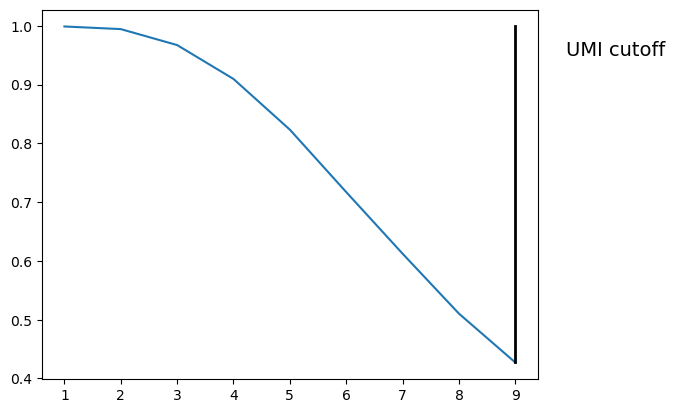

In [13]:
N_UMIS = 9
cell_data = {}
for lib,cell in zip(lib_names,cell_bcs):
    cell_data[(lib,cell)] = {}

for lib,cell,umi,BC in counts_filtered.keys():
    if (lib,cell) in cell_data:
        if not BC in cell_data[(lib,cell)]:
            cell_data[(lib,cell)][BC] = 0
        cell_data[(lib,cell)][BC] += 1

BC_lists = []
for i in range(1,10):
    BC_list = []
    for lib,cell in zip(lib_names,cell_bcs):
        bc_counts = cell_data[(lib,cell)]
        valid_bcs = [bc_map[k] for k,v in bc_counts.items() if v >= i]
        BC_list.append(','.join(sorted(valid_bcs))) # added a comma to separate multiple-barcode 
    BC_lists.append(BC_list)

efficiency = np.array([len([ll for ll in l if len(ll)>0]) for l in BC_lists]) / len(cell_bcs)
plt.plot(range(1,10),efficiency)
plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)

final_BCs = BC_lists[N_UMIS-1]
print('\nFinal annotation has '+repr(len(set(final_BCs)))+' clones in '+ repr(len([l for l in final_BCs if len(l)>0]))+' cells')

In [14]:
BC_set = sorted(set([bc for bc in final_BCs if bc != '']))
BC_set = list(map(lambda x: x.split(','), BC_set))
BC_set = list(itertools.chain.from_iterable(BC_set))
clone_mat = np.zeros((len(final_BCs),len(BC_set)))
for i,bc in enumerate(final_BCs):
    if bc != '':
        multi_bc = bc.split(',')
        for n in range(len(multi_bc)):
            j = BC_set.index(multi_bc[n])
            clone_mat[i,j] = 1
clone_mat = np.array(clone_mat,dtype=int)
np.savetxt('/scratch/users/yigit.babal/ferret/corrected_output/ED221124_matrix_UMI6_leven_read15_umi9.csv',clone_mat,delimiter=',',fmt='%i');
np.save('/scratch/users/yigit.babal/ferret/corrected_output/ED221124_matrix_UMI6_leven_read15_umi9.npy',clone_mat);
open('/scratch/users/yigit.babal/ferret/corrected_output/ED221124_barcode_list_leven_read15_umi9.txt','w').write('\n'.join(final_BCs));

In [15]:
clone_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
# how many columns (barcodes) have labeled 2 or more cells
multi_cc = np.sum(clone_mat, axis = 0)
sum(1 for i in multi_cc if i >= 2)

1202

In [17]:
# how cells have more than one barcode
multi_bc = np.sum(clone_mat, axis = 1)
sum(1 for i in multi_bc if i >= 2)

4237

In [18]:
clone_mat.shape

(20213, 19771)

In [19]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import figure

In [20]:
CLONE_MAT = '/scratch/users/yigit.babal/ferret/corrected_output/ED221124_matrix_UMI6_leven_read15_umi9.csv'
CLONE_NPY = '/scratch/users/yigit.babal/ferret/corrected_output/ED221124_matrix_UMI6_leven_read15_umi9.npy'
CELL_BCS = "/scratch/users/yigit.babal/ferret/corrected_output/ED221124_whitelist.txt"
DATASET = 'ED221124' 

In [21]:
# load csv file as pandas and numpy file to do boolean filtering
clone_mat = pd.read_csv(CLONE_MAT, error_bad_lines=False, header = None)
clone_mat_np = np.load(CLONE_NPY)
# read in cell bc file
# cell_bcs = open(CELL_BCS).read().strip('\n').split('\n') #use this to read in barcodes that are already in .txt file format
cell_bcs = pd.read_csv(CELL_BCS, sep='\t', header = None)

/local/jobs/15698540/ipykernel_254865/563010074.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  clone_mat = pd.read_csv(CLONE_MAT, error_bad_lines=False, header = None)


In [22]:
# examine dimensions of the matrix
clone_mat.shape

(20213, 19771)

In [23]:
# get rid of columns that label no clones. OR take out any columns where sum < 1 (i.e. does not label cell) 
multi_cc = np.sum(clone_mat_np, axis = 0)
multi_cc_bool = multi_cc >= 1
clone_mat = clone_mat.iloc[:,multi_cc_bool]
clone_mat_np = clone_mat_np[:,multi_cc_bool]
clone_mat.head()
clone_mat.shape

(20213, 18635)

In [24]:
# add cell bc column
clone_mat['cellbc'] = cell_bcs.loc[:,0].tolist()
clone_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,19762,19763,19764,19765,19766,19767,19768,19769,19770,cellbc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCAAGCATAGGC
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCAAGCTAAACA
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCAAGTCCTGTA
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCACAGATACTC
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCAGTCAAGCGA


In [25]:
# only keep rows (cells) that sum to up to 1 or more (i.e. must contain a lineage barcode)
sum_bc = np.sum(clone_mat_np, axis = 1)
sum_bc_bool = sum_bc >= 1
clone_mat = clone_mat.iloc[sum_bc_bool, :]
clone_mat_np = clone_mat_np[sum_bc_bool,:]
clone_mat.shape
clone_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,19762,19763,19764,19765,19766,19767,19768,19769,19770,cellbc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCAAGCATAGGC
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCAGTCAAGCGA
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCAGTTAACCTG
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCAGTTCATCTT
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AAACCCATCCCGAGTG


In [26]:
clone_mat.shape

(8636, 18636)

In [27]:
clone_mat.to_csv('/scratch/users/yigit.babal/ferret/corrected_output/ED221124_sparse_matrix_UMI3_leven_read15_umi9.csv')